In [1]:
import numpy as np

In [2]:
from sklearn.datasets import load_boston

In [ ]:
import matplotlib.pyplot as plt

## 构造基类

In [3]:
class Node:
    def __init__(self,inputs=[]):
        self.inputs=inputs
        self.value=None
        self.outputs=[]
        self.gradients={}
        for node in self.inputs:
            node.outputs.append(self)
    def forward(self):
        raise NotImplemented
    def backward(self):
        raise NotImplemented  

In [4]:
class Input(Node):
    
    def __init__(self,name = ''):
        Node.__init__(self,inputs = [])
        self.name = name
        
    def forward(self,value = None):
        if value is not None:
            self.value = value
            
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
            
    def __repr__(self):
        return 'Input Node:{}'.format(self.name)

In [5]:
class Linear(Node):
    def __init__(self,nodes,weights,bias):
        self.x_node = nodes
        self.w_node = weights
        self.b_node = bias
        Node.__init__(self,inputs = [nodes,weights,bias])
        
    def forward(self):
        self.value = np.dot(self.x_node.value,self.w_node.value)+ self.b_node.value
        
    def backward(self):
        
        for node in self.outputs:
            grad_cost = node.gradients[self]
            
            self.gradients[self.x_node] = np.dot(grad_cost,self.w_node.value.T)
            self.gradients[self.w_node] = np.dot(self.x_node.value.T,grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1,axis = 0,keepdims =False)

In [6]:
class Sigmoid(Node):
    def __init__(self,node):
        Node.__init__(self,[node])
        self.x_node = node
    
    def _sigmoid(self,x):
        return 1./(1+np.exp(-1*x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    
    def backward(self):
        y = self.value
        
        self.partial = y * (1-y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.x_node] = grad_cost * self.partial

In [7]:
W1 = np.array([[1, 1], [1, 2], [1, 3]])

In [8]:
W1.reshape(-1, 1)

array([[1],
       [1],
       [1],
       [2],
       [1],
       [3]])

In [9]:
class MSE(Node):
    def __init__(self,y_true,y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self,inputs = [y_true,y_hat])
        
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1,1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1,1)
        
        self.diff = y_true_flatten - y_hat_flatten
        
        self.value = np.mean(self.diff *2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2/n) * self.diff
        self.gradients[self.y_hat_node] = (-2/n) * self.diff

In [10]:
def training_one_batch(topological_sorted_graph):
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [11]:
def topological_sorted_sort(data_with_value):
    feed_dict = data_with_value
    inputs_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [n for n in inputs_nodes]
    while len(nodes)>0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {"in":set(),"out":set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {"in":set(),"out":set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
            
    L = []
    S = set(inputs_nodes)
    while len(S)>0:
        n =S.pop()
        
        if isinstance(n,Input):
            n.value = feed_dict[n]
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in'])==0:
                S.add(m)
    return L

In [12]:
def sgd_update(trainable_nodes,learning_rate = 1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [13]:
data = load_boston()

In [14]:
X_ = data['data']

In [15]:
X = np.array([1, 2, 3])
X

array([1, 2, 3])

In [16]:
Y_ = data['target']

In [17]:
X_ = (X_ - np.mean(X_,axis = 0))/ np.std(X_,axis =0)

In [18]:
X_.shape

(506, 13)

In [19]:
n_feature = X_.shape[1]

In [20]:
n_hidden = 10  #

In [21]:
n_hidden_2 = 10

In [22]:
w1_,b1_ = np.random.randn(n_feature,n_hidden),np.zeros(n_hidden)

In [23]:
w2_,b2_ = np.random.randn(n_hidden,1),np.zeros(1)

In [24]:
b1_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
b2_

array([0.])

# Build a graph connection ,Step:

## 1st:Build nodes in this graph

In [26]:
X,Y = Input(name='X'),Input(name='Y')
w1,b1 =Input(name='w1'),Input(name='b1')
w2,b2 =Input(name='w2'),Input(name='b2')

## 2rd:Build connection relationship

In [27]:
linear_output = Linear(X,w1,b1)
sigmoid_output = Sigmoid(linear_output)
Y_hat = Linear(sigmoid_output,w2,b2)
loss =MSE(Y,Y_hat)

## 我们可以把网络变得更为复杂

In [28]:
input_node_with_value = {
    X:X_,
    Y:Y_,
    w1:w1_,
    w2:w2_,
    b1:b1_,
    b2:b2_
}

In [29]:
graph = topological_sorted_sort(input_node_with_value)

In [30]:
graph

[Input Node:X,
 Input Node:b1,
 Input Node:w2,
 Input Node:b2,
 Input Node:Y,
 Input Node:w1,

In [31]:
from sklearn.utils import resample

In [32]:
np.random.choice(range(100),size = 10,replace =True)

array([35, 94,  3, 49, 64, 78,  4, 44, 24, 82])

In [33]:
def run(dictionary):
    return topological_sorted_sort(dictionary)

In [37]:
losses =[]
epochs =5000
batch_size = 64
step_per_epoch = X_.shape[0]//batch_size

for i in range(epochs):
    loss = 0
    for batch in range(step_per_epoch):
        X_batch,Y_batch = resample(X_,Y_,n_samples = batch_size)
        
        X_value = X_batch
        Y_value = Y_batch
        
        training_one_batch(graph)
        
        learning_rate =1e-3
        
        sgd_update(trainable_nodes = [w1,w2,b1,b2],learning_rate = learning_rate)
        
        loss +=graph[-1].value
    
    if i % 100 ==0:
        print('epoch:{},loss:{:.3f}'.format(i+1,loss/step_per_epoch))
        #print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

epoch:1,loss:-0.059
epoch:101,loss:-0.059
epoch:201,loss:-0.057
epoch:301,loss:-0.055
epoch:401,loss:-0.054
epoch:501,loss:-0.052
epoch:601,loss:-0.050
epoch:701,loss:-0.048
epoch:801,loss:-0.046
epoch:901,loss:-0.044
epoch:1001,loss:-0.042
epoch:1101,loss:-0.041
epoch:1201,loss:-0.040
epoch:1301,loss:-0.038
epoch:1401,loss:-0.037
epoch:1501,loss:-0.036
epoch:1601,loss:-0.035
epoch:1701,loss:-0.034
epoch:1801,loss:-0.033
epoch:1901,loss:-0.033
epoch:2001,loss:-0.032
epoch:2101,loss:-0.031
epoch:2201,loss:-0.030
epoch:2301,loss:-0.030
epoch:2401,loss:-0.029
epoch:2501,loss:-0.028
epoch:2601,loss:-0.027
epoch:2701,loss:-0.027
epoch:2801,loss:-0.026
epoch:2901,loss:-0.025
epoch:3001,loss:-0.024
epoch:3101,loss:-0.024
epoch:3201,loss:-0.023
epoch:3301,loss:-0.022
epoch:3401,loss:-0.022
epoch:3501,loss:-0.021
epoch:3601,loss:-0.021
epoch:3701,loss:-0.020
epoch:3801,loss:-0.020
epoch:3901,loss:-0.019
epoch:4001,loss:-0.019
epoch:4101,loss:-0.018
epoch:4201,loss:-0.018
epoch:4301,loss:-0.017


In [42]:
plt.plot(losses)

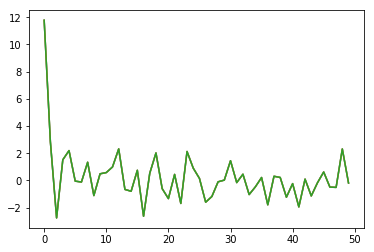

In [43]:
plt.show()